# TRADE OFF BIAS - VARIANCE

## 1. Import libraries

In [1]:
# !pip install -U scikit-learn
# !pip install mlxtend
# !pip install requests

In [2]:
# Basic
import numpy as np
import pandas as pd
import requests

# Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split

# Scipy
from scipy.interpolate import UnivariateSpline

# Bias-Variance Decomposition
from mlxtend.evaluate import bias_variance_decomp

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\dell\AppData\Local\Temp\ipykernel_4496\3759679660.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 2. Generating data

### 2.1. Generate feature data

We set the Random Seed to ensure Ensure reproducibility of the random processes in the simulation by fixing the seed for the random number generator.

In [3]:
# Set seed for random samples
np.random.seed(2024)

Then we create an array `X` with 401 evenly spaced values between 0 and 40.

In [4]:
# Generating 401 observations for X
X = np.arange(0, 40.1, 0.1)

### 2.2. Data Generation Model

We define a deterministic function of `X` that includes a linear term, `20*X`, and a non-linear term, `-90*sin(X)`, to simulate a real-world scenario. It is plotted to show the true underlying pattern without noise.

In [5]:
# Set the Data Generation Model DGM
dgm = 500 + 20*X - 90*np.sin(X)

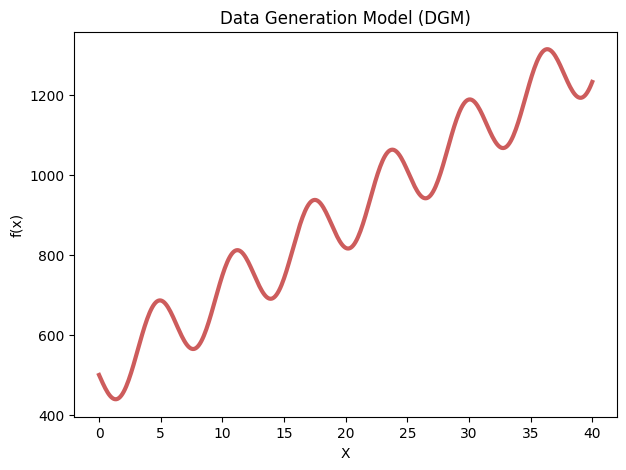

In [6]:
# Plot the Data Generation Model
plt.figure(figsize=(7, 5))
plt.plot(X, dgm, color='indianred', linewidth=3)
plt.title('Data Generation Model (DGM)')
plt.xlabel('X')
plt.ylabel('f(x)')
plt.show()

### 2.3. Generating the output data

We Simulate real-world data by adding normally distributed noise to the DGM, creating the response variable `y`. This is also plotted to visualize how the actual observations may look.

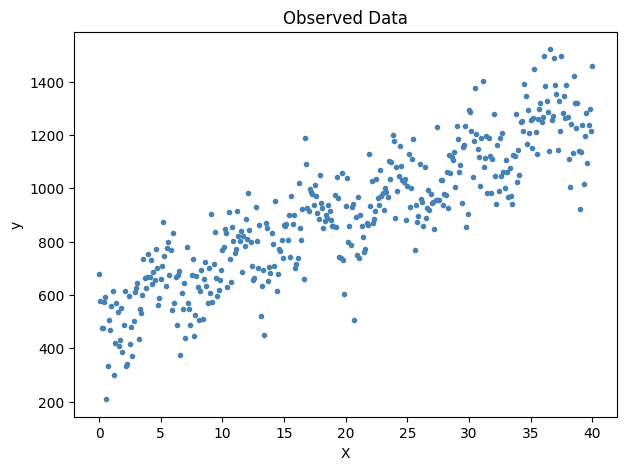

In [7]:
# Add some noise to data generation model
y = dgm + np.random.normal(10, 100, len(X))
plt.figure(figsize=(7, 5))
plt.plot(X, y, '.', color='steelblue')
plt.title('Observed Data')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

### 2.4. Set as DataFrame

We sctructure the simulated feature `X`, the noise-free DGM, and the noisy observations `y` into a DataFrame for ease of manipulation.

In [8]:
# y and X in a data frame
data = pd.DataFrame({'dgm': dgm, 'y': y, 'X': X})
data.head(5)

,dgm,y,X
0,500.000000,676.804732,0.0
1,493.014993,576.749765,0.1
2,486.119760,475.965984,0.2
3,479.403181,474.311987,0.3
4,472.952349,574.557530,0.4


### 2.5. Training - Test Split

We Randomly select 80% of the data for training the model and reserves the remaining 20% for testing its performance.

In [9]:
tot_obs = data.shape[0]
idx = np.random.choice(tot_obs, size=int(0.8 * tot_obs), replace=False)
training_sample = data.iloc[idx]
testing_sample = data.drop(idx)

### 2.6. Plotting Observed Data vs. Data Generation Model (DGM)

We compare the observed data with the underlying Data Generation Model (DGM)

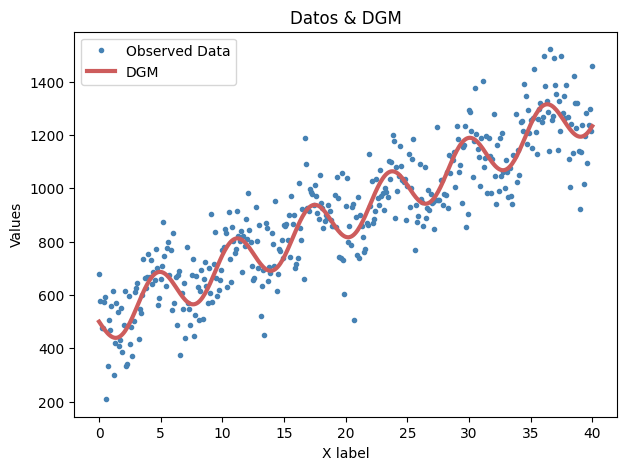

In [10]:
# Plotting the observed data and the Data Generation Model (DGM)
plt.figure(figsize=(7, 5))

# Plot observed data
plt.plot(X, y, '.', color='steelblue', label='Observed Data')

# Plot Data Generation Model (DGM)
plt.plot(X, dgm, color='indianred', linewidth=3, label='DGM')

# Additional plot settings
plt.title('Datos & DGM')
plt.xlabel('X label')
plt.ylabel('Values')
plt.legend()
plt.show()

## 3. Trade off Bias-Variance

Now, we will aim to estimate a model with the lowest possible error, measured using the RMSE (Root Mean Square Error) metric. To achieve this, we will implement three models with varying degrees of complexity: linear regression, polynomial regression, and spline regression.

### 3.1. Define and fit models

In [11]:
# 1) Linear Model
model1 = LinearRegression()
model1.fit(training_sample[['X']], training_sample['y'])

# 2) Polinomic model
poly_features = PolynomialFeatures(degree=12)
X_poly_train = poly_features.fit_transform(training_sample[['X']])
X_poly_test = poly_features.fit_transform(testing_sample[['X']])
model2 = LinearRegression()
model2.fit(X_poly_train, training_sample['y'])

# 3) Spline model
sorted_data = training_sample.sort_values(by='X')
X_sorted = sorted_data['X']
y_sorted = sorted_data['y']
model3 = UnivariateSpline(X_sorted, y_sorted, s=0, k=3)

### 3.2. Predict over training set and estimate the RSME

We obtain predictions and add those values to the DataFrame

In [12]:
predicted1 = model1.predict(training_sample[['X']])
predicted2 = model2.predict(X_poly_train)
predicted3 = model3(training_sample['X'])

training_sample_add = training_sample.copy(deep=True)
training_sample_add['linear_model_predict'] = predicted1
training_sample_add['polynomial_predict'] = predicted2
training_sample_add['spline_predict'] = predicted3

In [13]:
training_sample_add

,dgm,y,X,linear_model_predict,polynomial_predict,spline_predict
356,1289.729167,1259.265949,35.6,1216.332268,1289.232366,1259.265949
139,690.519325,681.492089,13.9,777.373804,816.576333,681.492089
306,1177.552469,1204.285492,30.6,1115.189765,1078.193337,1204.285492
361,1311.963923,1496.915035,36.1,1226.446518,1305.503318,1496.915035
375,1267.801892,1494.949054,37.5,1254.766419,1297.411910,1494.949054
...,...,...,...,...,...,...
380,1233.326828,1268.868363,38.0,1264.880670,1274.569659,1268.868363
396,1206.858868,1096.336798,39.6,1297.246271,1233.185286,1096.336798
70,580.871206,437.725929,7.0,637.797149,601.868624,437.725929
394,1198.760501,1197.497328,39.4,1293.200571,1224.027505,1197.497328


We define a function to estimate the RMSE

In [14]:
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

Then we estimate the RMSE and create and show results for the Training Set

In [15]:
rmse_linear = rmse(training_sample_add['y'], predicted1)
rmse_poly = rmse(training_sample_add['y'], predicted2)
rmse_spline = rmse(training_sample_add['y'], predicted3)

results = pd.DataFrame({
    "Models": ["Linear Model", "Polynomial Model", "Spline"],
    "RMSE": [rmse_linear, rmse_poly, rmse_spline]
})

results['RMSE'] = results['RMSE'].map('{:.15f}'.format)
results

,Models,RMSE
0,Linear Model,119.532096739087379
1,Polynomial Model,118.495885158349054
2,Spline,0.000000000000166


### 3.3. Linear Regression Model vs Data Generation Model (DGM)

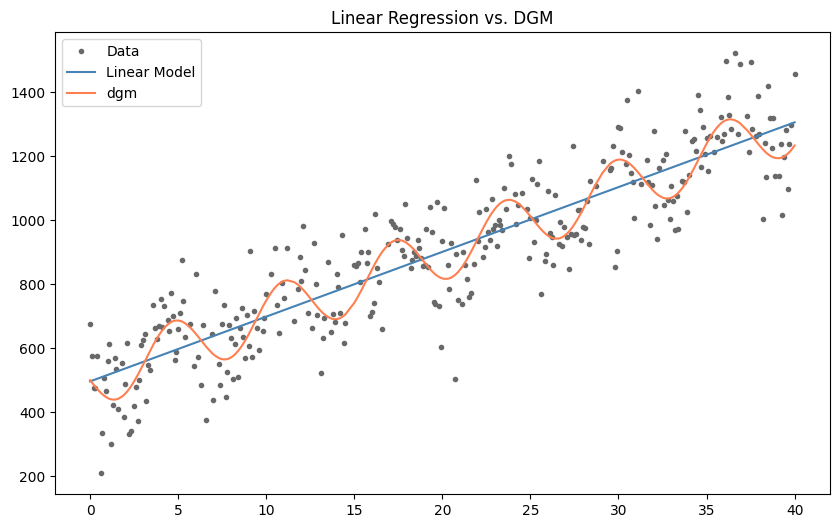

In [16]:
# Sort data
training_sample_reset = training_sample_add.reset_index()
sorted_indices = training_sample_reset['X'].argsort()
X_sorted = training_sample_reset.loc[sorted_indices, 'X']
y_sorted = training_sample_reset.loc[sorted_indices, 'y']
dgm_sorted = training_sample_reset.loc[sorted_indices, 'dgm']
predicted1_sorted = predicted1[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_sorted, y_sorted, '.', color='dimgray', label='Data')
plt.plot(X_sorted, predicted1_sorted, color='steelblue', label='Linear Model')
plt.plot(X_sorted, dgm_sorted, color='coral', label='dgm')
plt.legend()
plt.title('Linear Regression vs. DGM')
plt.show()

### 3.4. Polynomic Model vs Data Generation Model (DGM)

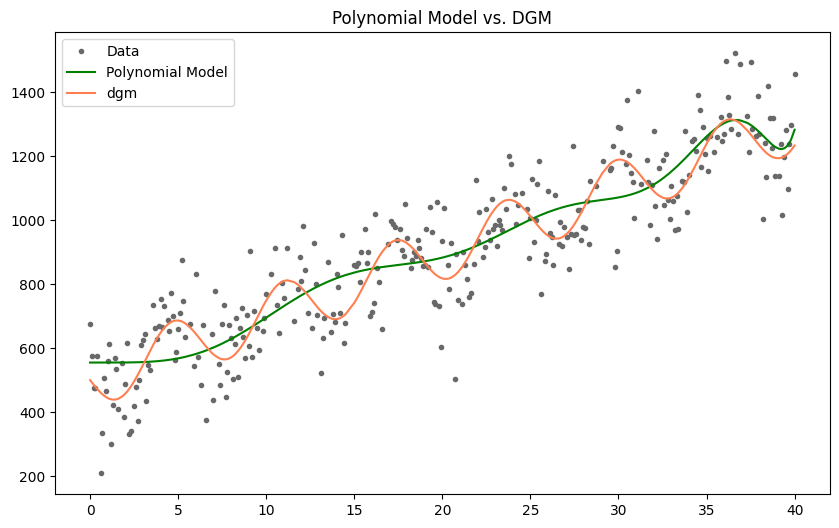

In [17]:
# Sort data
X_sorted = training_sample_reset.loc[sorted_indices, 'X']
predicted2_sorted = predicted2[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_sorted, y_sorted, '.', color='dimgray', label='Data')
plt.plot(X_sorted, predicted2_sorted, color='green', label='Polynomial Model')
plt.plot(X_sorted, dgm_sorted, color='coral', label='dgm')
plt.legend()
plt.title('Polynomial Model vs. DGM')
plt.show()

### 3.4. Spline Model vs Data Generation Model (DGM)

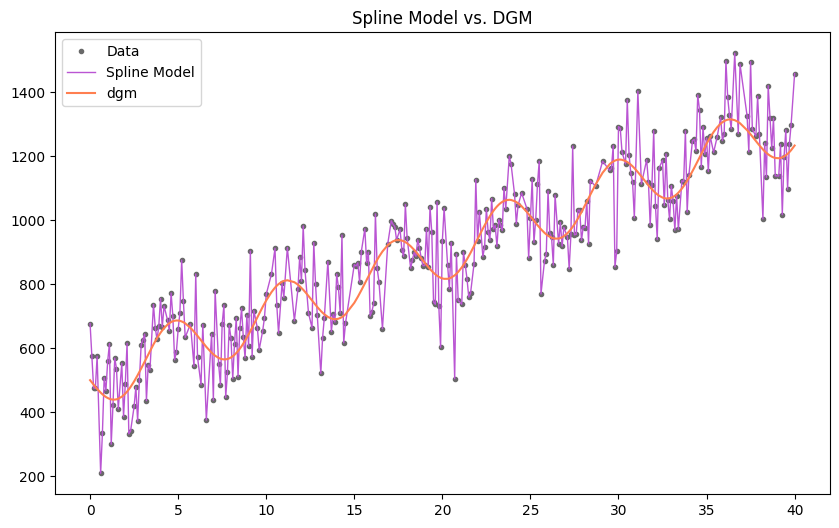

In [18]:
# Sort data
X_sorted = training_sample_reset.loc[sorted_indices, 'X']
predicted3_sorted = model3(X_sorted)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_sorted, y_sorted, '.', color='dimgray', label='Data')
plt.plot(X_sorted, predicted3_sorted, color='mediumorchid', label='Spline Model', linewidth=1)
plt.plot(X_sorted, dgm_sorted, color='coral', label='dgm')
plt.legend()
plt.title('Spline Model vs. DGM')
plt.show()

### 3.5. Testing error

So far, we have predicted and calculated the error on the training set. Now, we will do the same with the test set.

In [19]:
# Predict over the test set
predicted1_test = model1.predict(testing_sample[['X']])
predicted2_test = model2.predict(X_poly_test)
predicted3_test = model3(testing_sample['X'])

# Estimate the RMSE for the test set
rmse_linear_test = rmse(testing_sample['y'], predicted1_test)
rmse_poly_test = rmse(testing_sample['y'], predicted2_test)
rmse_spline_test = rmse(testing_sample['y'], predicted3_test)

# Compute the RMSE for the test set
results_test = pd.DataFrame({
    "Models": ["Linear Model", "Polynomial Model", "Spline"],
    "RMSE": [rmse_linear_test, rmse_poly_test, rmse_spline_test]
})

results_test

,Models,RMSE
0,Linear Model,122.774201
1,Polynomial Model,121.956186
2,Spline,175.764121


## 4. Bias and Variance Estimation

Now, let's decompose the mean squared error into bias and variance metrics. The idea is to observe how bias and variance vary across models of different complexities. To achieve this, let's use the ``train_test_split`` method to split data.

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(data['dep_vars'], data['target'], test_size=0.2, random_state=2)

In [21]:
X = data['X'].values.reshape(-1, 1)
y = data['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Now, we will import a wrapper ``SplineRegressor`` to make the spline model from the SciPy library compatible with the features of scikit-learn.

In [22]:
url = "https://raw.githubusercontent.com/josuecaldasv/utils/main/spline_wrapper.py"
response = requests.get(url)
exec(response.text)

Now, ee will refit the models on the training set

In [23]:
# 1) Linear Model
model1 = LinearRegression()
model1.fit(X_train, y_train)

# 2) Polinomic model
poly_features = PolynomialFeatures(degree=12)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.fit_transform(X_test)
model2 = LinearRegression()
model2.fit(X_poly_train, y_train)

# 3) Spline model (Approximation)
model3 = SplineRegressor(s=0, k=3)

Let's use the function ``bias_variance_decomp`` from the "mlxtend" library to calculate the bias, variance, and mean squared error (MSE) of the given models using the training and testing data provided (X_train, y_train, X_test, y_test). The loss function used for evaluating the performance is MSE, and it runs for 10 rounds with a random seed set to 2. TWe will estimate these metrics both on the training set and the test set.

In [24]:
# mse_lr, bias_lr, var_lr = bias_variance_decomp(model1, X_train, y_train, X_test, y_test, loss='mse', num_rounds=10, random_seed=2)

In [25]:
# Models tuples list
models = [
    ("Linear Model", model1, X_train, y_train, X_test, y_test),
    ("Polynomial Model", model2, X_poly_train, y_train, X_poly_test, y_test),
    ("Spline Model", model3, X_train, y_train, X_test, y_test)
]

# Bias - Variance Decomposition Estimation
results = []
for name, model, X_train_mod, y_train_mod, X_test_mod, y_test_mod in models:
    mse_train, bias_train, var_train = bias_variance_decomp(
        model, X_train_mod, y_train_mod, X_train_mod, y_train_mod, loss='mse', num_rounds=10, random_seed=2
    )
    mse_test, bias_test, var_test = bias_variance_decomp(
        model, X_train_mod, y_train_mod, X_test_mod, y_test_mod, loss='mse', num_rounds=10, random_seed=2
    )
    results.append({"Model": name, "MSE_train": mse_train, "Bias_train": bias_train, "Variance_train": var_train,
                    "MSE_test": mse_test, "Bias_test": bias_test, "Variance_test": var_test})

In [26]:
results_df = pd.DataFrame(results)
results_df

,Model,MSE_train,Bias_train,Variance_train,MSE_test,Bias_test,Variance_test
0,Linear Model,14330.147506,14258.122200,72.025306,15052.390406,14980.601351,71.789054
1,Polynomial Model,14587.062504,14172.156924,414.905580,14764.887622,14267.496827,497.390795
2,Spline Model,25989.245210,4218.082414,21771.162797,45036.606626,15614.091001,29422.515626


Finally we can plot the measures for the training and test set

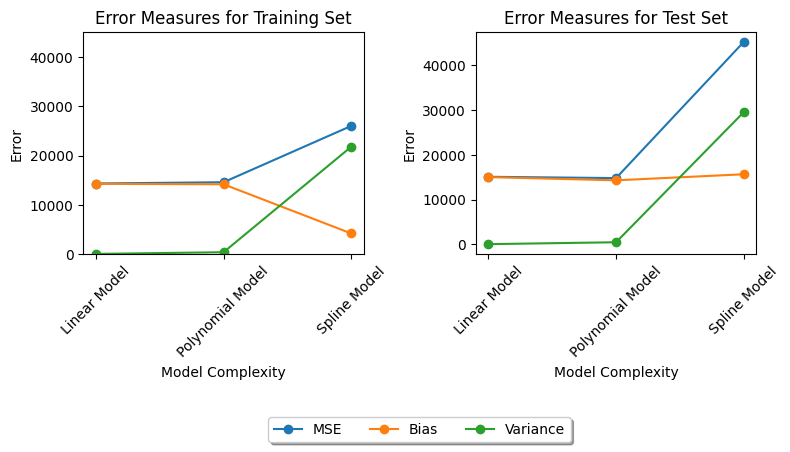

In [27]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot metrics for training set
ax1.plot(results_df['Model'], results_df['MSE_train'], marker='o', label='MSE')
ax1.plot(results_df['Model'], results_df['Bias_train'], marker='o', label='Bias')
ax1.plot(results_df['Model'], results_df['Variance_train'], marker='o', label='Variance')
ax1.set_title('Error Measures for Training Set')
ax1.set_xlabel('Model Complexity')
ax1.set_ylabel('Error')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, max(results_df[['MSE_train', 'Bias_train', 'Variance_train']].max()))

# Plot metrics for test set
ax2.plot(results_df['Model'], results_df['MSE_test'], marker='o', label='MSE')
ax2.plot(results_df['Model'], results_df['Bias_test'], marker='o', label='Bias')
ax2.plot(results_df['Model'], results_df['Variance_test'], marker='o', label='Variance')
ax2.set_title('Error Measures for Test Set')
ax2.set_xlabel('Model Complexity')
ax2.set_ylabel('Error')
ax2.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, max(results_df[['MSE_test', 'Bias_test', 'Variance_test']].max()))

# Adjust and show the plot
plt.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
ax2.legend(handles, labels, loc='upper center', bbox_to_anchor=(-0.2, -0.70), shadow=True, ncol=len(labels))

plt.show()